In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import datetime
import covid

from datetime import date
from covid import data
from covid.models import SEICHAR, SEICHARDemographic
from covid.utils import pm, pc, fmt


# Constants
now = datetime.datetime.now()
today = datetime.date(now.year, now.month, now.day)
day = datetime.timedelta(days=1)
gamma = 1/1.61
#plt.rcParams['figure.figsize'] = [10, 8]
sns.set(style="darkgrid")

In [2]:
# Números de casos São Paulo (metro)
start_date = datetime.date(2020, 1, 1)

confirmados = "0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,2,2,3,4,6,4,11,5,11,25,33,33,38,66,67,59,67,35,21,13,11,1,0,0,0,0,0,0,0,0,0,0"
confirmados = pd.Series([int(x) for x in confirmados.split(',')], index=dates)

suspeitos = "0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,3,2,7,3,3,3,3,0,1,0,10,7,7,10,8,18,15,19,33,31,74,85,103,77,143,202,225,308,530,629,669,830,987,919,854,926,655,673,575,700,606,547,508,301,124,42,2,0"
suspeitos = pd.Series([int(x) for x in suspeitos.split(',')], index=dates)

dates = [start_date + n * day for n in range(len(confirmados))]


# SRAG
lag = 7
srag_data = np.array([  5,   7,  13,   5,   6,  11,   3,   9,   5,   7,  13,   5,  17, 13,  35,  15,  21,  34,  21,  60,  66, 118, 114, 175, 185, 210, 287, 321, 326, 340, 288])
dates = [start_date + (n + 48) * day for n in range(len(srag_data))]
srag = pd.Series(srag_data, index=dates)
srag_lag = pd.Series(srag_data, index=np.array(dates) - lag * day)

#
cases = pd.DataFrame({'confirmed': confirmados, 'suspect': suspeitos, 'SRAG': srag, 'SRAG (1 week lag)': srag_lag})

d0, d1 = date(2020, 2, 20), date(2020, 3, 7)
# cases.loc[d0: d1].plot()
cases.plot()

plt.yscale('log')

NameError: name 'dates' is not defined

In [3]:
col = srag_lag
#col = suspeitos
linear = col.loc[d0:d1]

#col = confirmados
#linear = col.loc[d0:d1].iloc[4:]


t = np.arange(len(linear))
X = np.column_stack([t * 0 + 1, t])
y = np.log(linear.values)

# Exponential rate
ols = sm.OLS(y, X)
res = ols.fit()
print(res.summary())

# R0
sigma = 1 / 5.0
gamma = 1 / 1.61
import_rate = 0
K = res.params[1]
R0 = 1 + (sigma + gamma + K) * K / (sigma * gamma)
R0_SIR = 1 + K / gamma
R0, R0_SIR, len(t)

NameError: name 'srag_lag' is not defined

In [4]:
region = covid.region('Brazil/São Paulo (metro)')
# region = covid.region('Brazil')
kwargs = dict(
    region=region, 
    seed=1, 
    start_date=date(2020, 2, 25), 
    import_rate=import_rate, 
    prob_symptomatic=0.5,
)

ValueError: invalid geographic entity: 'São Paulo (metro)'

In [5]:
# R0 = 2.25
m0 = SEICHARDemographic(R0=R0, **kwargs)
m0.run(60)
m0.plot.healthcare_overflow(ymin=10)
print(m0.summary())

NameError: name 'R0' is not defined

In [9]:
t = np.linspace(0, 60)
R0_final = 1.13
time = 16

def Rt(t):
    exp = np.exp(-(t-16)/7)
    exp = np.where(exp > 1, 1, exp)
    return R0_final + (R0 - R0_final) * exp

plt.plot(t, Rt(t))

NameError: name 'R0' is not defined

In [10]:
m = SEICHARDemographic(R0=Rt, **kwargs)
m.run(2 * 365)
m.plot.healthcare_overflow(ymin=10)
print(m.summary())

NameError: name 'kwargs' is not defined

In [10]:
m0.data.loc[33].fatalities.sum()

12.460030925618177

In [11]:
m.icu_capacity

1113.7000000000016

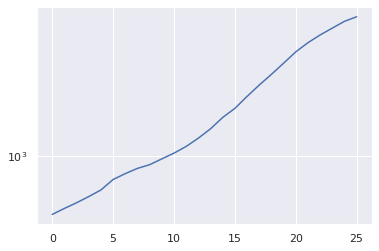

In [12]:
raw = '77,52,53,42,59,62,50,54,43,64,51,51,47,60,63,59,62,46,51,54,52,48,53,52,56,50,46,49,48,48,43,66,49,61,66,63,53,70,58,66,85,61,72,67,91,78,85,114,76,93,106,100,105,99,118,107,103,104,111,119,161,125,123,108,138,143,164,201,238,308,287,405,443,478,567,658,616,588,575,622,470,423,336,182,68,9'
cases = np.array(list(map(int, raw.split(','))), dtype=float)

delta = (date(2020, 2, 25) - start_date).days
covid = cases - cases[:delta].mean()
covid = np.where(covid > 0, covid, 0.0)
covid_cases = np.add.accumulate(covid)[delta:-5]
plt.plot(covid_cases)
plt.yscale('log')

In [13]:
t = np.arange(len(covid_cases))
X = np.column_stack([t * 0 + 1, t])
y = np.log(covid_cases)
ols = sm.OLS(y, X)
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           4.00e-24
Time:                        13:55:13   Log-Likelihood:                 23.508
No. Observations:                  26   AIC:                            -43.02
Df Residuals:                      24   BIC:                            -40.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9576      0.039    153.274      0.0

In [14]:
K = res.params[1]
R0 = 1 + (sigma + gamma + K) * K / (sigma * gamma)

In [ ]:
np.exp(5.95), R0

In [54]:
import io
data = pd.read_csv(io.StringIO("""1	2020-02-18	5
2	2020-02-19	7
3	2020-02-20	13
4	2020-02-21	5
5	2020-02-22	6
6	2020-02-23	11
7	2020-02-24	3
8	2020-02-25	9
9	2020-02-26	5
10	2020-02-27	7
11	2020-02-28	13
12	2020-02-29	5
13	2020-03-01	17
14	2020-03-02	13
15	2020-03-03	35
16	2020-03-04	15
17	2020-03-05	21
18	2020-03-06	34
19	2020-03-07	21
20	2020-03-08	60
21	2020-03-09	66
22	2020-03-10	118
23	2020-03-11	114
24	2020-03-12	175
25	2020-03-13	185
26	2020-03-14	210
27	2020-03-15	287
28	2020-03-16	321
29	2020-03-17	326
30	2020-03-18	340
31	2020-03-19	288""".replace('	', ',')), index_col=1, header=None)[[2]]

array([  5,   7,  13,   5,   6,  11,   3,   9,   5,   7,  13,   5,  17,
        13,  35,  15,  21,  34,  21,  60,  66, 118, 114, 175, 185, 210,
       287, 321, 326, 340, 288])

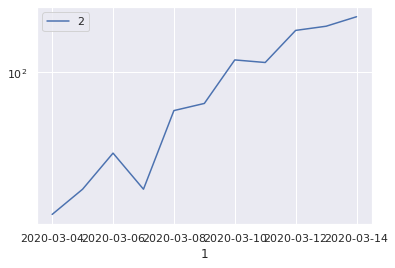

In [62]:
data.iloc[15:-5].plot()
plt.yscale('log')

data.values[:, 0]

In [57]:
y = np.log(data[2].values[13:-4])
t = np.arange(len(y))
X = np.column_stack([t*0 + 1, t])
res = sm.OLS(y, X).fit()
print(res.summary())
len(y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     111.7
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           1.96e-07
Time:                        16:53:26   Log-Likelihood:                -3.7235
No. Observations:                  14   AIC:                             11.45
Df Residuals:                      12   BIC:                             12.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5631      0.173     14.823      0.0

/usr/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


14

In [42]:
region = covid.region('Brazil/São Paulo (metro)')
m = SEICHARDemographic(region=region, R0=lambda t: 2.5 * np.exp(-t / 20) + 0.5, seed=1000)
m.run(60)

In [43]:
#m['fatalities'].sum(1).plot()
#m['infectious'].sum(1).plot()

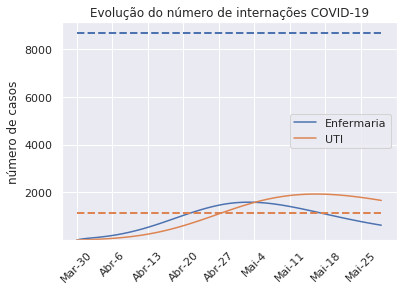

In [44]:
m.plot.healthcare_overflow(log=False)